In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import numpy as np

from datetime import datetime
from datetime import timedelta

import lightgbm as lgb
import shap

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

import warnings
warnings.filterwarnings("ignore") 

In [2]:
path = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [3]:
os.chdir('C:\\Users\\PC\\Documents\\odds')
odds_change_raw=pd.concat([pd.read_csv("final_odds_2018.csv"),pd.read_csv("final_odds_2019.csv")],axis=0).reset_index().drop(['index'],axis=1)
# odds_change_raw=pd.read_csv("final_odds_2019.csv")

# 1. 데이터 전처리

## 1.1 경기 결과 뽑기

In [4]:
odds_change_raw['home_score']=odds_change_raw['result'].str.split(':',expand=True)[0].astype(float)
odds_change_raw['away_score']=odds_change_raw['result'].str.split(':',expand=True)[1].astype(float)
odds_change_raw['game_date']=pd.to_datetime(odds_change_raw['game_date'].str.replace('(','').str.replace(')',''))
odds_change_raw['odds_change_date']=pd.to_datetime(odds_change_raw['odds_change_date'])
odds_change_raw['result']=np.where(odds_change_raw['home_score']>odds_change_raw['away_score'],'win',np.where(odds_change_raw['home_score']==odds_change_raw['away_score'],'draw','lose'))

## 1.2 Feature Engineering

In [5]:
def get_10_min_bef(x,result,sec):
    try:
        return x.loc[x['odds_change_date']<x['game_date'].iloc[0]-timedelta(seconds=sec)][result].iloc[-1]/2+x.loc[x['odds_change_date']>x['game_date'].iloc[0]-timedelta(seconds=sec)][result].iloc[0]/2
    except:
        return np.nan

a2=odds_change_raw.groupby(['game_link']).apply(lambda x: x['result'].iloc[0]).reset_index(name='result')
a3=odds_change_raw.groupby(['game_link']).apply(lambda x: x['win'].iloc[-1]).reset_index(name='final_win_bedang')
a4=odds_change_raw.groupby(['game_link']).apply(lambda x: x['win'].iloc[0]).reset_index(name='first_win_bedang')
a5=odds_change_raw.groupby(['game_link']).apply(lambda x: x['draw'].iloc[-1]).reset_index(name='final_draw_bedang')
a6=odds_change_raw.groupby(['game_link']).apply(lambda x: x['draw'].iloc[0]).reset_index(name='first_draw_bedang')
a7=odds_change_raw.groupby(['game_link']).apply(lambda x: x['lose'].iloc[-1]).reset_index(name='final_lose_bedang')
a8=odds_change_raw.groupby(['game_link']).apply(lambda x: x['lose'].iloc[0]).reset_index(name='first_lose_bedang')
a9=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'win',600)).reset_index(name='10_win')
a10=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'draw',600)).reset_index(name='10_draw')
a11=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'lose',600)).reset_index(name='10_lose')
a12=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'win',3600)).reset_index(name='60_win')
a13=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'draw',3600)).reset_index(name='60_draw')
a14=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'lose',3600)).reset_index(name='60_lose')
a18=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'win',120)).reset_index(name='2_win')
a19=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'draw',120)).reset_index(name='2_draw')
a20=odds_change_raw.groupby(['game_link']).apply(lambda x: get_10_min_bef(x,'lose',120)).reset_index(name='2_lose')

In [8]:
odds=pd.merge(a2,a3,on='game_link',how='left')
odds=pd.merge(odds,a4,on='game_link',how='left')
odds=pd.merge(odds,a5,on='game_link',how='left')
odds=pd.merge(odds,a6,on='game_link',how='left')
odds=pd.merge(odds,a7,on='game_link',how='left')
odds=pd.merge(odds,a8,on='game_link',how='left')
odds=pd.merge(odds,a9,on='game_link',how='left')
odds=pd.merge(odds,a10,on='game_link',how='left')
odds=pd.merge(odds,a11,on='game_link',how='left')
odds=pd.merge(odds,a12,on='game_link',how='left')
odds=pd.merge(odds,a13,on='game_link',how='left')
odds=pd.merge(odds,a14,on='game_link',how='left')
odds=pd.merge(odds,a18,on='game_link',how='left')
odds=pd.merge(odds,a19,on='game_link',how='left')
odds=pd.merge(odds,a20,on='game_link',how='left')
odds=pd.merge(odds,odds_change_raw[['game_link','league_name']].drop_duplicates(['game_link']),on='game_link',how='left')

In [9]:
for i in ['win','draw','lose']:
    odds['diff_'+i]=odds['final_'+i+'_bedang']-odds['first_'+i+'_bedang']

    odds['diff_2_first'+i]=odds['2_'+i]-odds['first_'+i+'_bedang']
    odds['diff_10_'+i]=odds['final_'+i+'_bedang']-odds['10_'+i]
    odds['diff_60_'+i]=odds['final_'+i+'_bedang']-odds['60_'+i]

    odds['diff_2_60_'+i]=odds['2_'+i]-odds['60_'+i]
    odds['diff_10_60_'+i]=odds['10_'+i]-odds['60_'+i]

## 1.3 베팅 시 수익 타겟값 생성

In [10]:
odds['win_bet_profit']=np.where(odds['result']=='win',odds['final_win_bedang']-1,-1)
odds['draw_bet_profit']=np.where(odds['result']=='draw',odds['final_draw_bedang']-1,-1)
odds['lose_bet_profit']=np.where(odds['result']=='lose',odds['final_lose_bedang']-1,-1)
odds['result']=odds['result'].map({'win':2,'draw':1,'lose':0})

## 1.4 모델링을 위한 준비

In [11]:
param = {'num_leaves': 10,
         'min_data_in_leaf': 5,
         'objective': 'regression',
         'max_depth': 10,
         'learning_rate': 0.0125,
         "min_child_samples": 10,
         "boosting": "gbdt",
         "feature_fraction": 0.7,
         "bagging_freq": 1,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.2,
         "verbosity": -1,
         'random_state':9}

In [12]:
folds = KFold(n_splits=5,shuffle=True,random_state=219)

In [13]:
def get_pred(train,target,odds_ts,param=param):
#     pred_val=np.zeros(len(train))
    pred_ts=np.zeros(len(odds_ts))

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
        trn_data = lgb.Dataset(train.iloc[trn_idx],label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx],label=target.iloc[val_idx])

        num_round = 10000
        clf = lgb.train(param,
                        trn_data,
                        num_round,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=0,
                        early_stopping_rounds = 200)


#         pred_val[val_idx] = clf.predict(train.iloc[val_idx], num_iteration=clf.best_iteration)

        pred_ts += clf.predict(odds_ts[features], num_iteration=clf.best_iteration)
    return clf,pred_ts

In [14]:
features=['first_win_bedang','first_draw_bedang','first_lose_bedang',
          '2_win', '2_draw', '2_lose',
          'diff_2_firstwin','diff_2_firstdraw','diff_2_firstlose',
          'diff_2_60_win','diff_2_60_draw','diff_2_60_lose']

In [15]:
odds_under=odds.loc[odds['final_win_bedang']<2.21].reset_index().drop(['index'],axis=1)
odds_over=odds.loc[odds['final_win_bedang']>2.21].reset_index().drop(['index'],axis=1)

In [16]:
def val_data_shap_value(game_link_index,feature_names,odds=odds):

#     odds_tr=odds.loc[~odds['game_link'].isin([temp_game_link])]
#     odds_ts=odds.loc[odds['game_link'].isin([temp_game_link])]

    odds_tr = odds.drop(game_link_index, errors="ignore")
    odds_ts = odds.iloc[game_link_index:game_link_index+1]

    train=odds_tr[features]
    lgb1,odds_ts['win_prof']=get_pred(train,odds_tr['win_bet_profit'],odds_ts,param)
    odds_tr['result']=odds_tr['result'].map({2:'win',1:'draw',0:'lose'})
    odds_ts['result']=odds_ts['result'].map({2:'win',1:'draw',0:'lose'})

    explainer = shap.TreeExplainer(lgb1)
    shap_values = explainer.shap_values(odds_ts[features])

    shap_impact=pd.DataFrame({'league':odds_ts['league_name']})
    for i in feature_names:
        shap_impact[i+'_value']=odds_ts[i]
        shap_impact[i+'_impact']=shap_values[:,features.index(i)]

    return shap_impact

# 2. 홈 승 배당이 2.21보다 낮을 때(feat 정배)

타겟값(수익률)에 각 변수가 어떠한 영향을 미치는 지 알기 위해 SHAP value를 활용한다.

##### SHAP value 탐색 과정
1. 데이터에서 한 개의 row만 odds_ts로 잡고, 나머지는 모두 odds_tr으로 잡는다.
2. odds_tr에서 5_fold_cross_validation을 이용해 5개의 Lightgbm을 train함과 동시에 odds_ts의 수익률을 5번 예측해서 평균을 낸다.
3. 이렇게 나온 예측치에 대한 shap_value를 구해, 해당 변수가 수익률에 가지는 impact를 산정한다.
4. 이 과정을 모든 row에 대해서 진행한다.

In [17]:
agg_under={}
index=0
for temp_game_link in range(len(odds_under)):
    index+=1
    if index%100==0:
        print(index)

    agg_under[odds_under['game_link'].iloc[temp_game_link]]=val_data_shap_value(temp_game_link,['diff_2_firstwin', '2_win'],odds_under)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [18]:
shap_impact_under=pd.concat(agg_under,ignore_index=True)

shap value를 구한 후, 각 변수가 수익률에 어떤 영향을 주는지 시각화한다.

## 2.1. 초기배당에서 베팅 마감 2분전까지 홈 승 배당의 변화

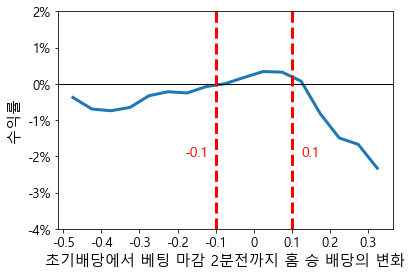

In [19]:
impact=[]
value=[]
for i in range(40):
    if len(shap_impact_under.loc[(shap_impact_under['diff_2_firstwin_value']>=i*0.05-1)&(shap_impact_under['diff_2_firstwin_value']<=i*0.05-1+0.05)])>10:
        impact.append(shap_impact_under.loc[(shap_impact_under['diff_2_firstwin_value']>=i*0.05-1)&(shap_impact_under['diff_2_firstwin_value']<=i*0.05-1+0.05)]['diff_2_firstwin_impact'].mean())
        value.append((i*0.05-1+i*0.05-1+0.05)/2)
        

plt.plot(value,impact,linewidth=3)
plt.axhline(0, color='k', linewidth=1)
plt.xlabel('초기배당에서 베팅 마감 2분전까지 홈 승 배당의 변화',fontsize=15)
plt.ylabel('수익률',fontsize=15)
plt.yticks([-0.04,-0.03,-0.02,-0.01,0,0.01,0.02], 
           ['-4%','-3%','-2%','-1%','0%','1%','2%'],
           fontsize=13
          )
plt.xticks([-0.5,-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3], 
           ['-0.5','-0.4','-0.3','-0.2','-0.1','0','0.1','0.2','0.3'],
           fontsize=13
          )
plt.text(-0.18,-0.02,'-0.1',color='r',fontsize=14)
plt.text(0.125,-0.02,'0.1',color='r',fontsize=14)
plt.axvline(0.1, color='r', linestyle='--', linewidth=3)
plt.axvline(-0.1, color='r', linestyle='--', linewidth=3)

위 그림을 보면 배당이 +-0.1보다 크게 변동하는 경기에 베팅시 수익률이 급감하는 모습을 보인다. 따라서 배당이 +-0.1 범위 내에서 움직이는 경기에만 홈 승에 베팅하는 것이 좋다.

## 2.2. 2분 전 승 배당

In [47]:
train=odds_under[features]
lgb1,odds_under['win_prof']=get_pred(train,odds_under['win_bet_profit'],odds_under,param)

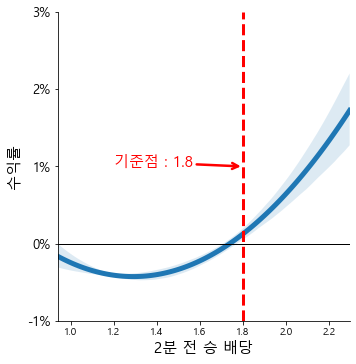

In [55]:
temp=odds_under.loc[(odds_under['diff_2_firstwin']<0.1)&(odds_under['diff_2_firstwin']>-0.1)]

temp=temp.rename(columns={'2_win':'2분 전 승 배당','win_prof':'승리에 걸었을 시 수익률'})


sns.lmplot('2분 전 승 배당','승리에 걸었을 시 수익률',data=temp,order=2, line_kws=dict(linewidth=5),scatter=False)
plt.xlabel('2분 전 승 배당',fontsize=15)
plt.ylabel('수익률',fontsize=15)

plt.axvline(1.8, color='r', linestyle='--', linewidth=3)
plt.axhline(0, color='k', linewidth=1)
plt.annotate("기준점 : 1.8", xy=(1.8, 0.1), xytext=(1.2,0.1), arrowprops=dict(arrowstyle="->",color='r',lw=2.5),color='r',fontsize=15)
plt.yticks([-0.1, 0, 0.1 ,0.2 ,0.3], 
           ['-1%','0%','1%','2%','3%'],
           fontsize=13
          )
plt.show()

위 그림을 보면 2분전 배당이 1.8을 넘어가는 경기에 베팅 시 수익률이 급상승한다. 따라서 배당이 1.8 이상인 경기에만 홈 승에 베팅하는 것이 좋아 보인다.

## 2.3. 전략(홈 승 배당이 2.21보다 낮을 때)

#### 1.	베팅 마감 2분 전까지 배당의 변화 +-0.1 이내인 경기<br>2.	베팅 마감 2분 전 홈 승 배당이 1.8을 넘는 경기
#### 위의 두 가지 조건을 만족하는 경기에 “홈 승”을 픽

## 2.4. 전략 수익률 테스트

In [58]:
odds=pd.merge(odds,odds_change_raw[['game_link','game_date']].drop_duplicates(),on=['game_link'],how='left')
odds['game_date']=pd.to_datetime(odds['game_date'].astype(str).str.slice(0,10))
odds=odds.rename(columns={'game_date':'날짜'})
odds['result']=odds['result'].map({2:'win',1:'draw',0:'lose'})

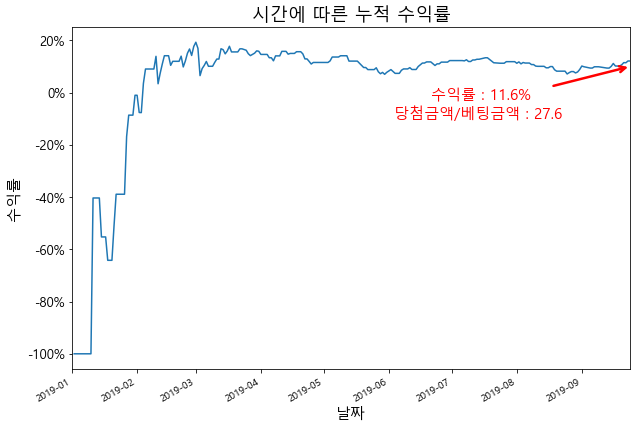

In [68]:
profit=[]

for i in range(len(odds)):
    
    if (np.abs(odds['diff_2_firstwin'].iloc[i])<0.1)&(odds['2_win'].iloc[i]>1.8)&(odds['final_win_bedang'].iloc[i]<2.21):
        if odds['result'].iloc[i]=='win':
            profit.append(odds['final_win_bedang'].iloc[i]-1)
        else:
            profit.append(-1)
    else:
        profit.append(np.nan)
odds['profit']=profit


plt.figure(figsize=(10, 7))
odds.groupby(['날짜']).apply(lambda x: odds.loc[odds['날짜']<x['날짜'].iloc[0]]['profit'].mean()).plot()
plt.title('시간에 따른 누적 수익률',fontsize=18)
plt.annotate("        수익률 : 11.6% \n 당첨금액/베팅금액 : 27.6", xy=(pd.to_datetime('2019-09-24'), 0.1), xytext=(pd.to_datetime('2019-06-01'),-0.1), arrowprops=dict(arrowstyle="->",color='r',lw=2.5),color='r',fontsize=15)

plt.xlabel('날짜',fontsize=15)
plt.ylabel('수익률',fontsize=15)

plt.yticks([-1, -0.8, -0.6 ,-0.4 ,-0.2,0, 0.2], 
           ['-100%','-80%','-60%','-40%','-20%','0%','20%'],
           fontsize=13
          )

plt.show()

위의 전략대로 베팅 시뮬레이션을 돌려본 결과 2019년 1월부터 9월까지 승률 55.6%, 평균 수익률 11.6%을 기록했다.

# 3. 홈 승 배당이 2.21보다 높을 때(feat 역배)

In [20]:
agg_over={}
index=0
for temp_game_link in range(len(odds_over)):
    index+=1
    if index%100==0:
        print(index)

    agg_over[odds_over['game_link'].iloc[temp_game_link]]=val_data_shap_value(temp_game_link,['diff_2_60_win', '2_win'],odds_over)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600


In [21]:
shap_impact_over=pd.concat(agg_over,ignore_index=True)

## 3.1. 베팅마감 1시간 전부터 2분 전까지 홈 승 배당 변화

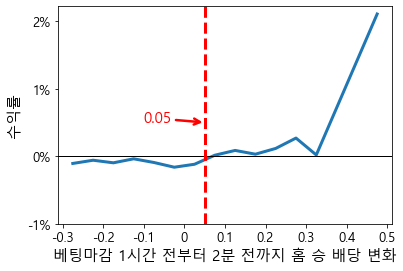

In [22]:
impact=[]
value=[]
for i in range(40):
    if len(shap_impact_over.loc[(shap_impact_over['diff_2_60_win_value']>=i*0.05-1)&(shap_impact_over['diff_2_60_win_value']<=i*0.05-1+0.05)])>10:
        impact.append(shap_impact_over.loc[(shap_impact_over['diff_2_60_win_value']>=i*0.05-1)&(shap_impact_over['diff_2_60_win_value']<=i*0.05-1+0.05)]['diff_2_60_win_impact'].mean())
        value.append((i*0.05-1+i*0.05-1+0.05)/2)
        

plt.plot(value,impact,linewidth=3)
plt.axhline(0, color='k', linewidth=1)

plt.xlabel('베팅마감 1시간 전부터 2분 전까지 홈 승 배당 변화',fontsize=15)
plt.ylabel('수익률',fontsize=15)
plt.yticks([-0.01,0,0.01,0.02], 
           ['-1%','0%','1%','2%'],
           fontsize=13
          )
plt.xticks([-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4,0.5], 
           ['-0.3','-0.2','-0.1','0','0.1','0.2','0.3','0.4','0.5'],
           fontsize=13
          )

# plt.text(-0.05,0.005,'0.1',color='r',fontsize=14)
plt.annotate("0.05", xy=(0.05,0.005), xytext=(-0.1,0.005), arrowprops=dict(arrowstyle="->",color='r',lw=2.5),color='r',fontsize=15)

plt.axvline(0.05, color='r', linestyle='--', linewidth=3)

위 그림을 보면 0.05보다 큰 폭으로 상승하는 경기에 베팅시 수익률이 좋다. 따라서 배당이 1시간 전부터 2분전까지 0.05보다 크게 증가하는 경기에만 홈 승에 베팅하는 것이 수익률이 극대화되는 방향이다.

## 3.2. 2분 전 승 배당

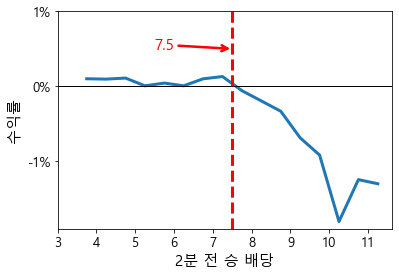

In [40]:
impact=[]
value=[]
for i in range(40):
    if len(shap_impact_over.loc[(shap_impact_over['2_win_value']>=i*0.5+2)&(shap_impact_over['2_win_value']<=i*0.5+0.5+2)])>5:
        impact.append(shap_impact_over.loc[(shap_impact_over['2_win_value']>=i*0.5+2)&(shap_impact_over['2_win_value']<=i*0.5+0.5+2)]['2_win_impact'].mean())
        value.append((i*0.5+2+i*0.5+0.5+2)/2)

        

plt.plot(value,impact,linewidth=3)
plt.axhline(0, color='k', linewidth=1)

plt.xlabel('2분 전 승 배당',fontsize=15)
plt.ylabel('수익률',fontsize=15)
plt.yticks([-0.01,0,0.01], 
           ['-1%','0%','1%'],
           fontsize=13
          )
plt.xticks([3,4,5,6,7,8,9,10,11],#[1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5], 
           ['3','4','5','6','7','8','9','10','11'],
           fontsize=13
          )

# # plt.text(-0.05,0.005,'0.1',color='r',fontsize=14)
plt.annotate("7.5", xy=(6,0.005), xytext=(4,0.005), arrowprops=dict(arrowstyle="->",color='r',lw=2.5),color='r',fontsize=15)

plt.axvline(6, color='r', linestyle='--', linewidth=3)

위 그림을 보면 2분전 홈 승 배당이 7.5을 넘어가는 경기에 베팅 시 수익률이 급감하는 모습을 보인다. 따라서 7.5 이하인 경기에 홈 승을 베팅하는 것이 좋다.

## 3.3. 전략(홈 승 배당이 2.21보다 높을 때)

#### 1.	배당이 1시간전부터 2분 전까지 0.05 이상 오르는 경기<br>2.	2분 전 홈 승 배당이 7.5 이하인 경기
#### 위의 두 가지 조건을 만족하는 경기에 “홈 승”을 픽

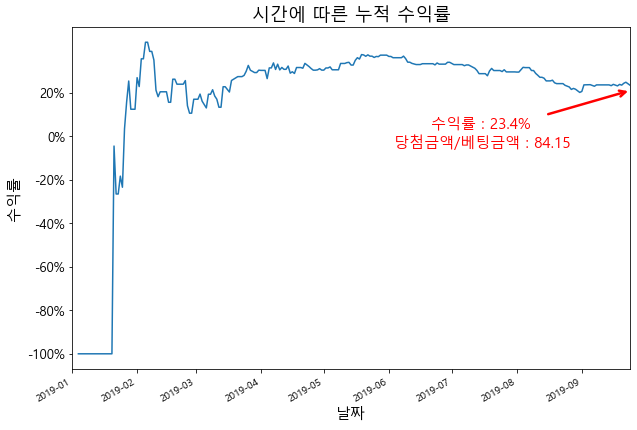

In [74]:
profit=[]

for i in range(len(odds)):
    
    if (odds['2_win'].iloc[i]<7.5)&(odds['diff_2_60_win'].iloc[i]>0.05)&(odds['final_win_bedang'].iloc[i]>2.21):
        if odds['result'].iloc[i]=='win':
            profit.append(odds['final_win_bedang'].iloc[i]-1)
        else:
            profit.append(-1)
    else:
        profit.append(np.nan)
odds['profit']=profit


plt.figure(figsize=(10, 7))
odds.groupby(['날짜']).apply(lambda x: odds.loc[odds['날짜']<x['날짜'].iloc[0]]['profit'].mean()).plot()
plt.title('시간에 따른 누적 수익률',fontsize=18)
plt.annotate("        수익률 : 23.4% \n 당첨금액/베팅금액 : 84.15", xy=(pd.to_datetime('2019-09-24'), 0.21), xytext=(pd.to_datetime('2019-06-01'),-0.05), arrowprops=dict(arrowstyle="->",color='r',lw=2.5),color='r',fontsize=15)

plt.xlabel('날짜',fontsize=15)
plt.ylabel('수익률',fontsize=15)

plt.yticks([-1, -0.8, -0.6 ,-0.4 ,-0.2,0, 0.2], 
           ['-100%','-80%','-60%','-40%','-20%','0%','20%'],
           fontsize=13
          )

plt.show()

위의 전략대로 베팅 시뮬레이션을 돌려본 결과 2019년 1월부터 9월까지 승률 34.5%, 수익률 23.4%을 기록했다.

# 4. 위의 두 전략 모두 활용 시 수익률

In [77]:
profit=[]
for i in range(len(odds)):
    if ((odds['2_win'].iloc[i]<7.5)&(odds['diff_2_60_win'].iloc[i]>0.05)&(odds['final_win_bedang'].iloc[i]>2.21))|((np.abs(odds['diff_2_firstwin'].iloc[i])<0.1)&(odds['2_win'].iloc[i]>1.8)&(odds['final_win_bedang'].iloc[i]<2.21)):
        if odds['result'].iloc[i]=='win':
            profit.append(odds['final_win_bedang'].iloc[i]-1)
        else:
            profit.append(-1)
print('수익률 : ' +str(np.mean(profit)*100)+'%')#+', 합은 '+str(np.sum(profit)))

수익률 : 18.75%


위의 전략들을 모두 사용해 조건에 맞는 경우 홈 팀에 베팅하는 시뮬레이션을 돌려본 결과 2019년 1월부터 9월까지 평균 수익률 18.75%을 기록했다.